In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
%matplotlib inline

In [31]:
input_dir = "../output/"
transformations_path = os.path.join(input_dir, "transformations.npy")
transformations = np.load(transformations_path)

In [32]:
print(f"Nombre de transformations chargées : {len(transformations)}")

Nombre de transformations chargées : 47


In [33]:
def create_simple_3d_model(transformations):
    points = np.zeros((len(transformations) + 1, 3), dtype=np.float64)
    current_point = np.array([0, 0, 0], dtype=np.float64)
    
    for i, M in enumerate(transformations):
        translation = M[:3, 2]
        current_point += translation
        points[i+1] = current_point
    
    return points

In [34]:
points_3d = create_simple_3d_model(transformations)

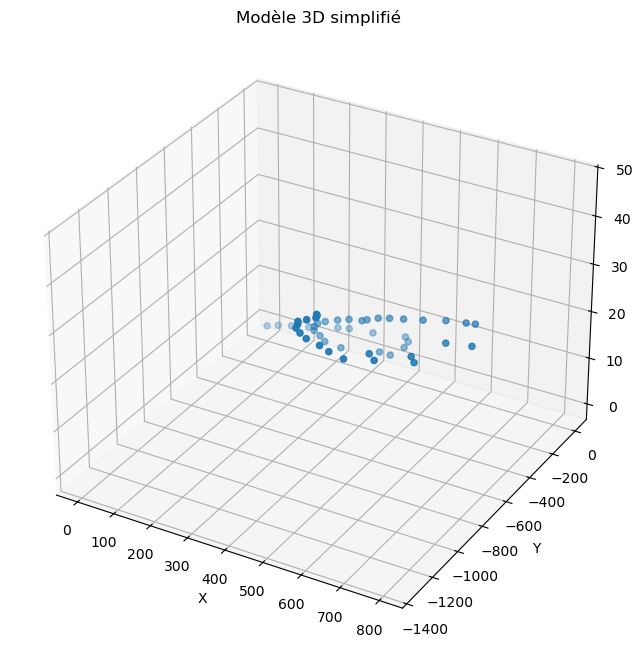

In [35]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Modèle 3D simplifié")
plt.show()


In [36]:
def evaluate_model(points_3d):
    distances = np.linalg.norm(np.diff(points_3d, axis=0), axis=1)
    avg_distance = np.mean(distances)
    variance = np.var(distances)
    return avg_distance, variance

In [37]:
vg_distance, variance = evaluate_model(points_3d)

In [38]:
print(f"Distance moyenne entre les points : {avg_distance:.2f}")
print(f"Variance des distances : {variance:.2f}")

Distance moyenne entre les points : 51.96
Variance des distances : 2335.79


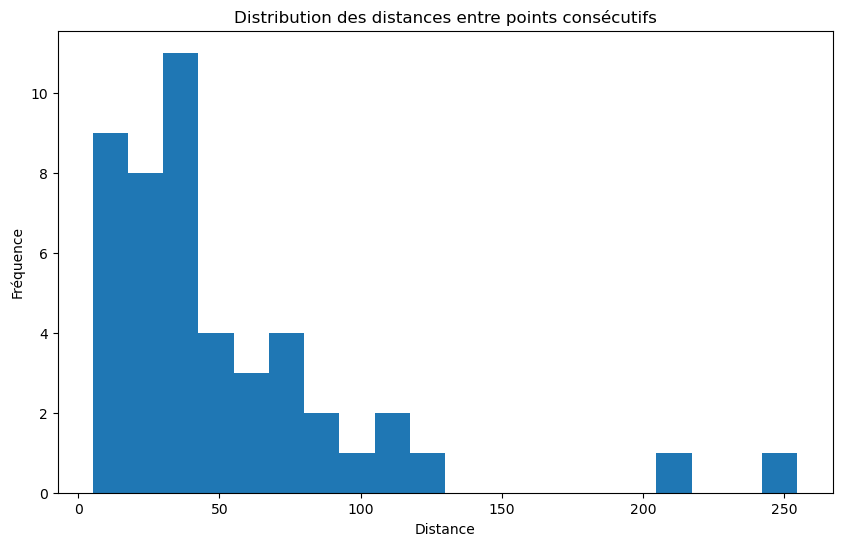

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(np.linalg.norm(np.diff(points_3d, axis=0), axis=1), bins=20)
plt.title("Distribution des distances entre points consécutifs")
plt.xlabel("Distance")
plt.ylabel("Fréquence")
plt.show()

In [40]:
total_distance = np.sum(np.linalg.norm(np.diff(points_3d, axis=0), axis=1))
print(f"Distance totale parcourue : {total_distance:.2f}")

Distance totale parcourue : 2443.14


In [41]:
max_distance = np.max(np.linalg.norm(np.diff(points_3d, axis=0), axis=1))
min_distance = np.min(np.linalg.norm(np.diff(points_3d, axis=0), axis=1))

In [42]:
print(f"Distance maximale entre deux points consécutifs : {max_distance:.2f}")
print(f"Distance minimale entre deux points consécutifs : {min_distance:.2f}")

Distance maximale entre deux points consécutifs : 254.57
Distance minimale entre deux points consécutifs : 5.15


In [43]:
def approximate_curvature(points):
    vectors = np.diff(points, axis=0)
    angles = np.arccos(np.sum(vectors[:-1] * vectors[1:], axis=1) / 
                       (np.linalg.norm(vectors[:-1], axis=1) * np.linalg.norm(vectors[1:], axis=1)))
    return np.mean(angles)

In [44]:
curvature = approximate_curvature(points_3d)
print(f"Courbure moyenne approximative : {curvature:.4f} radians")

print("Évaluation du modèle terminée.")

Courbure moyenne approximative : 0.5593 radians
Évaluation du modèle terminée.
